
전력 사용량 예측 AI 경진대회
--

전력 | 한국에너지공단 | 시계열 | SMAPE
--

train.csv : train 데이터 : 60개 건물들의 2020년 6월 1일 부터 2020년 8월 24일까지의 데이터 1시간 단위로 제공 전력사용량(kWh) 포함 train.shape: (122400, 10)

test.csv : test 데이터 : 60개 건물들의 2020년 8월 25일 부터 2020년 8월 31일까지의 데이터 3시간 단위로 제공(강수량의 경우 6시간 단위로 제공, 예보데이터) 전력사용량(kWh) 미포함 test.shape: (10080, 9)

sample_submission.csv : sample_submission 데이터 sample_submission.shape: (10080, 2)

In [ ]:
from google.colab import files
files.upload()

In [1]:
import io
import pandas as pd

train=pd.read_csv('train.csv', encoding='cp949', parse_dates=['date_time'])
test=pd.read_csv('test.csv', encoding='cp949', parse_dates=['date_time'])
sample_submission=pd.read_csv('sample_submission.csv', encoding='cp949', parse_dates=['num_date_time'] )

In [2]:
df_train=pd.DataFrame(train)
df_test=pd.DataFrame(test) 
df_sample_submission=pd.DataFrame(sample_submission)

시간칼럼 분류
--

In [3]:
df_train['time'] = df_train['date_time'].dt.strftime('%m%d%H')
df_train['month_day'] = df_train['date_time'].dt.strftime('%m%d')
df_train['month']=df_train['date_time'].dt.strftime('%m')
df_train['date']=df_train['date_time'].dt.strftime('%d')
df_train['hour']=df_train['date_time'].dt.strftime('%H')
df_train['day']=df_train['date_time'].dt.strftime('%A')

df_test['time'] = df_test['date_time'].dt.strftime('%m%d%H')
df_test['month_day'] = df_test['date_time'].dt.strftime('%m%d')
df_test['month']=df_test['date_time'].dt.strftime('%m')
df_test['date']=df_test['date_time'].dt.strftime('%d')
df_test['hour']=df_test['date_time'].dt.strftime('%H')
df_test['day']=df_test['date_time'].dt.strftime('%A')

In [4]:
tn_month_day=pd.Series(df_train['month_day'], dtype=int)
tn_month=pd.Series(df_train['month'], dtype=int)
tn_date=pd.Series(df_train['date'], dtype=int)
tn_hour=pd.Series(df_train['hour'], dtype=int)
tn_time=pd.Series(df_train['time'], dtype=int)

te_month_day=pd.Series(df_test['month_day'], dtype=int)
te_month=pd.Series(df_test['month'], dtype=int)
te_date=pd.Series(df_test['date'], dtype=int)
te_hour=pd.Series(df_test['hour'], dtype=int)
te_time=pd.Series(df_test['time'], dtype=int)

df_train['month_day'] =tn_month_day
df_train['month']=tn_month
df_train['date']=tn_date
df_train['hour']=tn_hour
df_train['time']=tn_time

df_test['month_day']=te_month_day
df_test['month']=te_month
df_test['date']=te_date
df_test['hour']=te_hour
df_test['time']=te_time

EDA
--

1. 시간과 전력사용량 관계

[Text(0, 0.5, 'kWh'), Text(0.5, 1.0, 'month')]

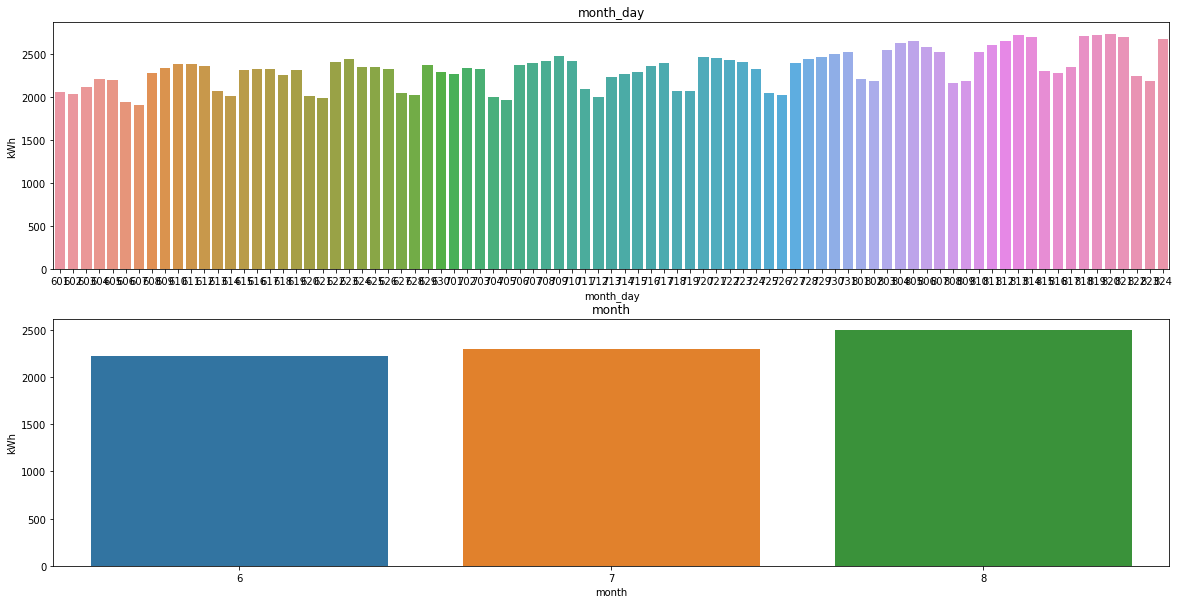

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

figure, ((ax1), (ax2)) =plt.subplots(nrows=2,ncols=1)
figure.set_size_inches(20,10)

md=df_train.groupby('month_day')['전력사용량(kWh)'].mean().reset_index()
m=df_train.groupby('month')['전력사용량(kWh)'].mean().reset_index()

sns.barplot(data=md, x="month_day", y='전력사용량(kWh)', ax=ax1)

sns.barplot(data=m, x="month", y='전력사용량(kWh)', ax=ax2)

sns.set_style("darkgrid")
ax1.set(ylabel='kWh', title ="month_day")
ax2.set(ylabel='kWh', title ="month")

[Text(0, 0.5, 'kWh'), Text(0.5, 1.0, 'hour')]

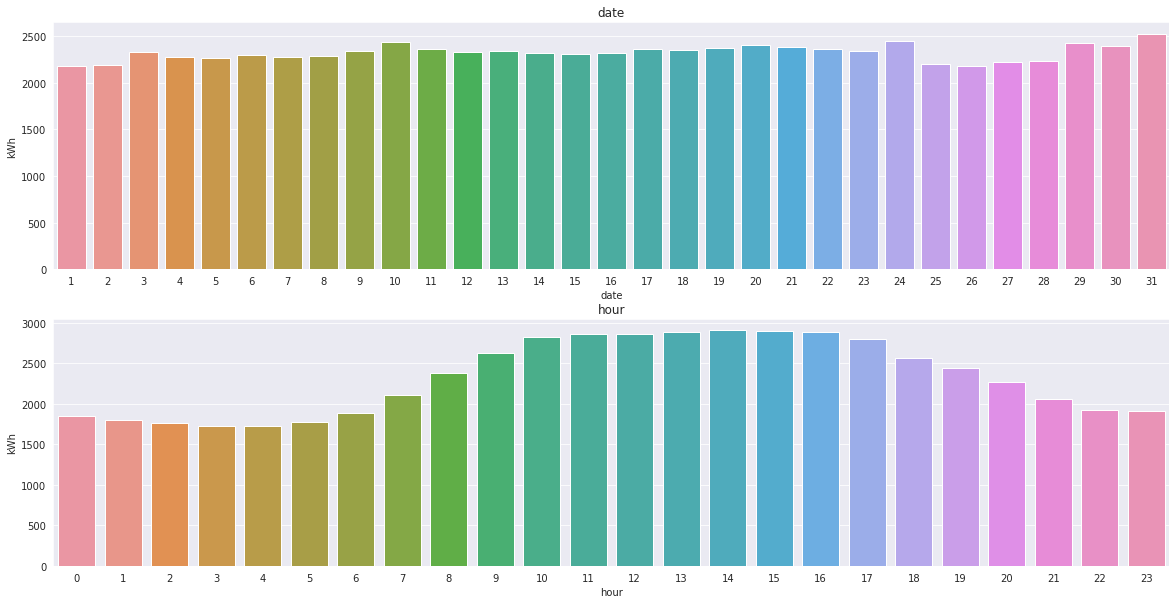

In [6]:
import seaborn as sns

figure, ( (ax3), (ax4)) =plt.subplots(nrows=2,ncols=1)
figure.set_size_inches(20,10)

date=df_train.groupby('date')['전력사용량(kWh)'].mean().reset_index()
h=df_train.groupby('hour')['전력사용량(kWh)'].mean().reset_index()

sns.barplot(data=date, x="date", y='전력사용량(kWh)', ax=ax3)

sns.barplot(data=h, x="hour", y='전력사용량(kWh)', ax=ax4)

ax3.set(ylabel='kWh', title ="date")
ax4.set(ylabel='kWh', title ="hour")

[Text(0, 0.5, 'kWh'), Text(0.5, 1.0, 'day')]

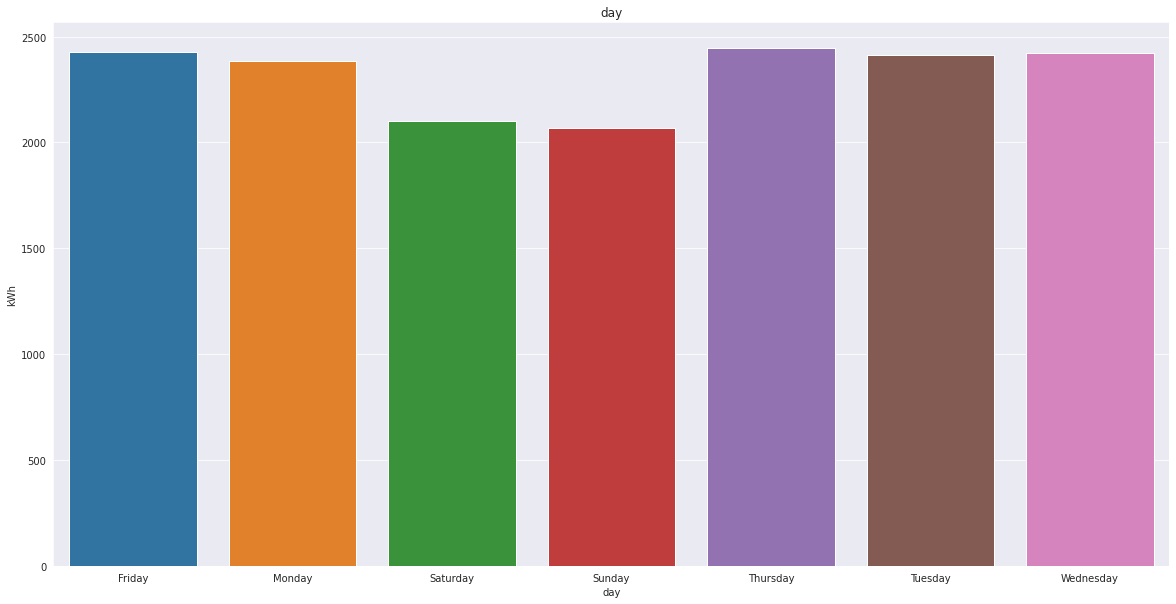

In [7]:
import seaborn as sns

figure, (ax5) =plt.subplots(nrows=1,ncols=1)
figure.set_size_inches(20,10)

day=df_train.groupby('day')['전력사용량(kWh)'].mean().reset_index()

sns.barplot(data=day, x="day", y='전력사용량(kWh)', ax=ax5)

sns.set_style("darkgrid")
ax5.set(ylabel='kWh', title ="day")

건물번호와 전력사용량 관계
--

In [8]:
building_num=df_train.groupby(['num'])['전력사용량(kWh)'].sum().reset_index()

[Text(0, 0.5, 'kWH'), Text(0.5, 1.0, 'num and kWh')]

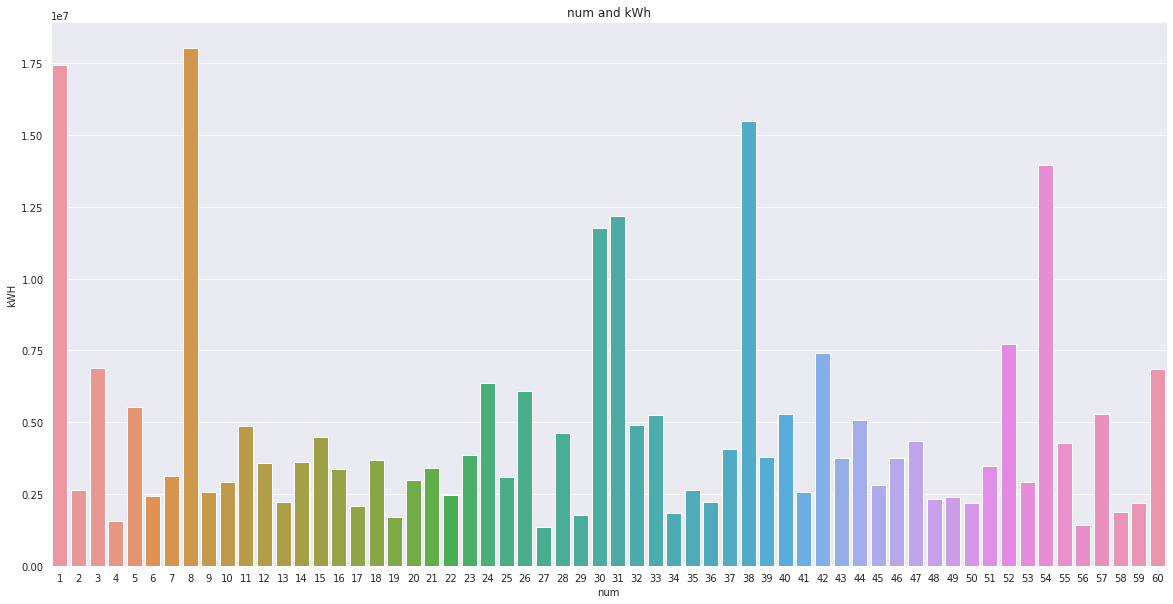

In [9]:
figure, (ax1) =plt.subplots(nrows=1,ncols=1)
figure.set_size_inches(20,10)

sns.barplot(data=building_num, x='num', y='전력사용량(kWh)', ax=ax1)

ax1.set(ylabel='kWH', title='num and kWh')

- 8번 건물이 가장 전력을 많이 사용하였습니다.

모델에 적용할 데이터 가공하기
--

In [42]:
fb_train=df_train.groupby(['num','month_day','date_time' ])['전력사용량(kWh)'].sum().reset_index()

In [43]:
fb_train['ds']=fb_train['date_time']
fb_train['y']=fb_train['전력사용량(kWh)']

In [44]:
fb_train

,num,month_day,date_time,전력사용량(kWh),ds,y
0,1,601,2020-06-01 00:00:00,8179.056,2020-06-01 00:00:00,8179.056
1,1,601,2020-06-01 01:00:00,8135.640,2020-06-01 01:00:00,8135.640
2,1,601,2020-06-01 02:00:00,8107.128,2020-06-01 02:00:00,8107.128
3,1,601,2020-06-01 03:00:00,8048.808,2020-06-01 03:00:00,8048.808
4,1,601,2020-06-01 04:00:00,8043.624,2020-06-01 04:00:00,8043.624
...,...,...,...,...,...,...
122395,60,824,2020-08-24 19:00:00,4114.368,2020-08-24 19:00:00,4114.368
122396,60,824,2020-08-24 20:00:00,3975.696,2020-08-24 20:00:00,3975.696
122397,60,824,2020-08-24 21:00:00,3572.208,2020-08-24 21:00:00,3572.208
122398,60,824,2020-08-24 22:00:00,3299.184,2020-08-24 22:00:00,3299.184


In [45]:
fb_train.drop(['date_time','전력사용량(kWh)'], axis=1, inplace=True)

In [46]:
fb_train

,num,month_day,ds,y
0,1,601,2020-06-01 00:00:00,8179.056
1,1,601,2020-06-01 01:00:00,8135.640
2,1,601,2020-06-01 02:00:00,8107.128
3,1,601,2020-06-01 03:00:00,8048.808
4,1,601,2020-06-01 04:00:00,8043.624
...,...,...,...,...
122395,60,824,2020-08-24 19:00:00,4114.368
122396,60,824,2020-08-24 20:00:00,3975.696
122397,60,824,2020-08-24 21:00:00,3572.208
122398,60,824,2020-08-24 22:00:00,3299.184


In [47]:
fb_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   num        122400 non-null  int64         
 1   month_day  122400 non-null  int64         
 2   ds         122400 non-null  datetime64[ns]
 3   y          122400 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.7 MB


8/24~8/31 전력사용량 예측
--

Train데이터에 마지막 7일을 test 데이터로 지정하여 결과 비교해보기
--

In [48]:
fb_train_tn=fb_train.loc[fb_train['month_day']<818]

In [49]:
fb_train_te=fb_train.loc[fb_train['month_day']>=818]

In [18]:
fb_train.columns

Index(['num', 'month_day', 'ds', 'y'], dtype='object')

In [19]:
y_test=fb_train_te['y']

Prophet 불러오기
--

기본 모델로 예측해보기

In [20]:
from fbprophet import Prophet

In [ ]:
answer=[]

for i in range(1,61):
    fb_1=fb_train_tn.loc[fb_train_tn['num']==i]
    model=Prophet()
    model.fit(fb_1)
    future=model.make_future_dataframe(periods=168, freq='H')
    forecast=model.predict(future)
    pred=forecast['yhat']
    answer.append(pred)
    i+=1


In [22]:
import numpy as np

answer2=pd.DataFrame(answer)
answer3=answer2.iloc[:, 1872:2040]
answer4=np.array(answer3)
answer5=answer4.reshape(-1,1)
answer6=pd.DataFrame(answer5)

In [23]:
df_sample_submission['answer']=answer6[0]

In [24]:
from sklearn.metrics import mean_squared_error

y_test_pred=df_sample_submission['answer']
rmse=(np.sqrt(mean_squared_error(y_test, y_test_pred)))

print('rmse 는', format(rmse), '입니다.')

rmse 는 465.54035716912716 입니다.


모델 시각화
--

8번 회사가 가장 전력사용량이 많으므로, 8번 회사를 기준으로 시각화를 해보겠습니다.

In [25]:
fb_8=fb_train_tn.loc[fb_train_tn['num']==8]
model=Prophet()
model.fit(fb_8)
future=model.make_future_dataframe(periods=168, freq='H')
forecast=model.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


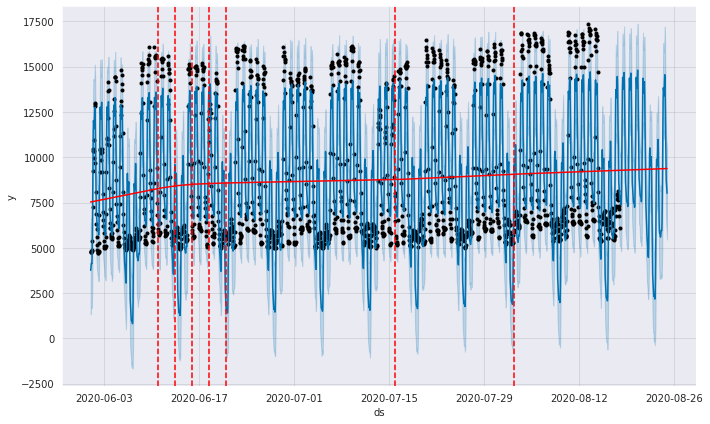

In [26]:
from fbprophet.plot import add_changepoints_to_plot

fig1=model.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), model, forecast)

In [ ]:
fig1=model.plot_components(forecast)

하이퍼 파라미터 적용하기
--

1. growth = logisitic or linear 설정
2. changepoint_range로 범위 조정
3. changepoint_prior_scale로 변동점을 찾는 유동성 변경
( 하이퍼 파라미터의 값을 올리면 좀 더 유동적으로 찾으나, 너무 높으면, 데이터에 오버피팅 우려가 있고, 너무 낮으면, 언더피팅의 우려가 있음.)

4.  변동점의 숫자를 정하고 싶으면 n_changepoints 파라미터 숫자를 바꾸면 됨.

5. 계절성의 조정: yearly_seasonality, weekly_seasonality,
daily_seasonality
(이 값을 올리면 계절성의 fitting이 더 복잡해짐. default=10)

6. seasonality_mode = multiplicative로 설정하면 좀 더 데이터에 맞는 모델이 구축 됨.

7. seasonality_prior_scale: 전체 데이터에서의 계절성의 영향도를 조정하는 파라미터로 값을 낮추면, 계절성의 영향도를 낮출 수 있다. (default=10)


In [28]:
# EDA 과정에서 보았듯이, 전체적으로 month_day, month, hour, date에 따라 변화가 있다. 이를 하이퍼파라미터에 적용해준다.
#
#model = Prophet(growth="linear", changepoints=None, changepoint_range=0.5, 
#                n_changepoints=25, changepoint_prior_scale=0.5, 
#                seasonality_mode="multiplicative",
#                seasonality_prior_scale=5,
#                interval_width=0.99,
#                mcmc_samples=300,
#                yearly_seasonality="auto", 
#                weekly_seasonality="auto", 
#                daily_seasonality=False,
#                holidays=None)
#
# Specifying Custom Seasonalities
#model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
#model.add_country_holidays(country_name='KR')
#
#model.fit(fb_8)
#future=model.make_future_dataframe(periods=168, freq='H')
#forecast=model.predict(future)

In [29]:
#from fbprophet.plot import add_changepoints_to_plot
#
#fig1=model.plot(forecast)
#a = add_changepoints_to_plot(fig1.gca(), model, forecast)

In [30]:
#fig1=model.plot_components(forecast)

In [31]:
# 소요시간: 2시간 58분 47초에서 정지됨.
#
#answer=[]
#
#for i in range(1,61):
#    fb_1=fb_train_tn.loc[fb_train_tn['num']==i]
#    model = Prophet(growth="linear", changepoints=None, changepoint_range=0.5, 
#                n_changepoints=25, changepoint_prior_scale=0.5, 
#                seasonality_mode="multiplicative",
#                seasonality_prior_scale=5,
#                interval_width=0.99,
#                mcmc_samples=300,
#                yearly_seasonality="auto", 
#                weekly_seasonality="auto", 
#                daily_seasonality=False,
#                holidays=None)
#
#    # Specifying Custom Seasonalities
#    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
#    model.add_country_holidays(country_name='KR')
#
#    model.fit(fb_1)
#    future=model.make_future_dataframe(periods=168, freq='H')
#    forecast=model.predict(future)
#    pred=forecast['yhat']
#    answer.append(pred)
#    i+=1

In [32]:
#import numpy as np
#
#answer2=pd.DataFrame(answer)
#answer3=answer2.iloc[:, 1872:2040]
#answer4=np.array(answer3)
#answer5=answer4.reshape(-1,1)
#answer6=pd.DataFrame(answer5)
#df_sample_submission['answer']=answer6[0]
#
#from sklearn.metrics import mean_squared_error
#
#y_test_pred=df_sample_submission['answer']
#rmseh=(np.sqrt(mean_squared_error(y_test, y_test_pred)))
#
#print('rmse 는', format(rmse), '입니다.')
#print('hyper 파라미터 적용 후 rmse 는', format(rmseh), '입니다.')

Neural Prophet
--

In [ ]:
pip install neuralprophet

In [35]:
from neuralprophet import NeuralProphet

In [ ]:
fb_train_tn.drop(['month_day'], axis=1, inplace=True)

In [52]:
fb_train_tn

,num,ds,y
0,1,2020-06-01 00:00:00,8179.056
1,1,2020-06-01 01:00:00,8135.640
2,1,2020-06-01 02:00:00,8107.128
3,1,2020-06-01 03:00:00,8048.808
4,1,2020-06-01 04:00:00,8043.624
...,...,...,...
122227,60,2020-08-17 19:00:00,4261.248
122228,60,2020-08-17 20:00:00,4202.064
122229,60,2020-08-17 21:00:00,4036.608
122230,60,2020-08-17 22:00:00,3850.416


In [ ]:
answer=[]

for i in range(1,61):
    fb_1=fb_train_tn.loc[fb_train_tn['num']==i]
    fb_2=fb_1.drop(['num'], axis=1)
    model=NeuralProphet()
    model.fit(fb_2, freq='H')
    future=model.make_future_dataframe(fb_2, periods=168)
    forecast=model.predict(future)
    pred=forecast['yhat1']
    answer.append(pred)
    i+=1

In [79]:
import numpy as np

answer2=pd.DataFrame(answer)
answer3=np.array(answer2)
answer4=answer3.reshape(-1,1)
answer5=pd.DataFrame(answer4)

In [80]:
df_sample_submission['answer']=answer5[0]

In [82]:
from sklearn.metrics import mean_squared_error

y_test_pred=df_sample_submission['answer']
rmse=(np.sqrt(mean_squared_error(y_test, y_test_pred)))

print('rmse 는', format(rmse), '입니다.')

rmse 는 464.8126767664477 입니다.


모델 시각화
--

8번 회사가 가장 전력사용량이 많으므로, 8번 회사를 기준으로 시각화를 해보겠습니다.

In [ ]:
fb_8=fb_train_tn.loc[fb_train_tn['num']==8]
fb_81=fb_8.drop(['num'], axis=1)
model=NeuralProphet()
model.fit(fb_81, freq='H')
future=model.make_future_dataframe(fb_81, periods=168)
forecast=model.predict(future)

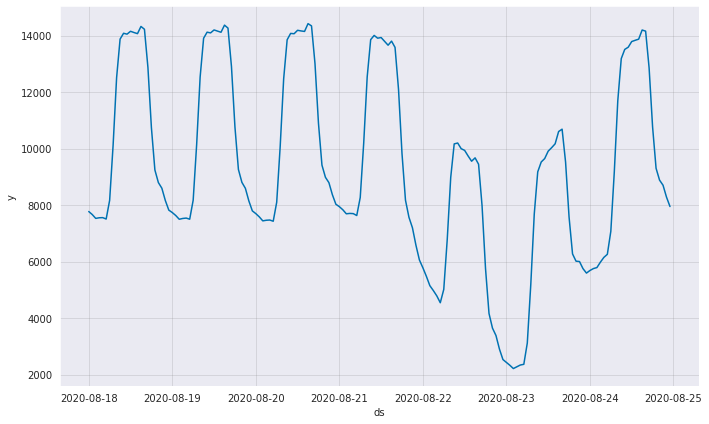

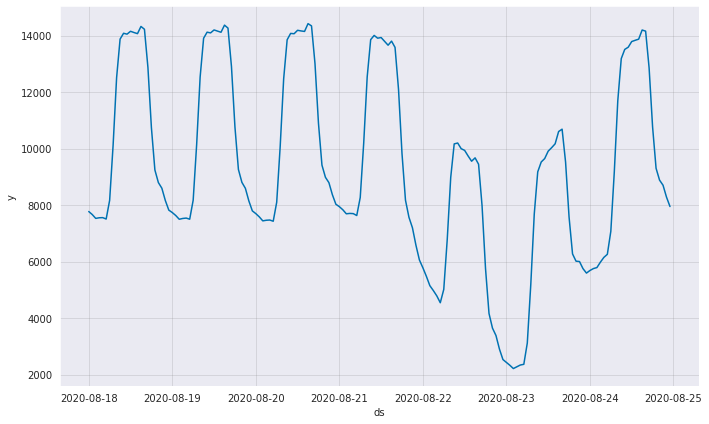

In [84]:
model.plot(forecast)

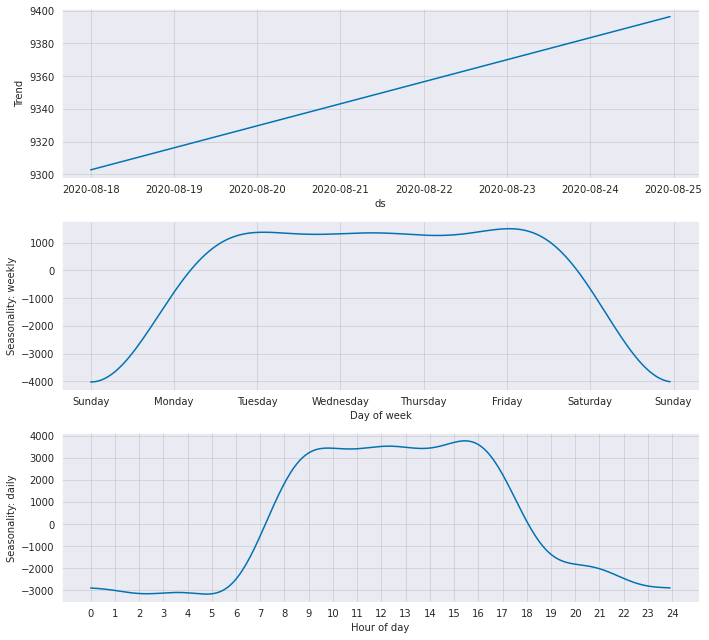

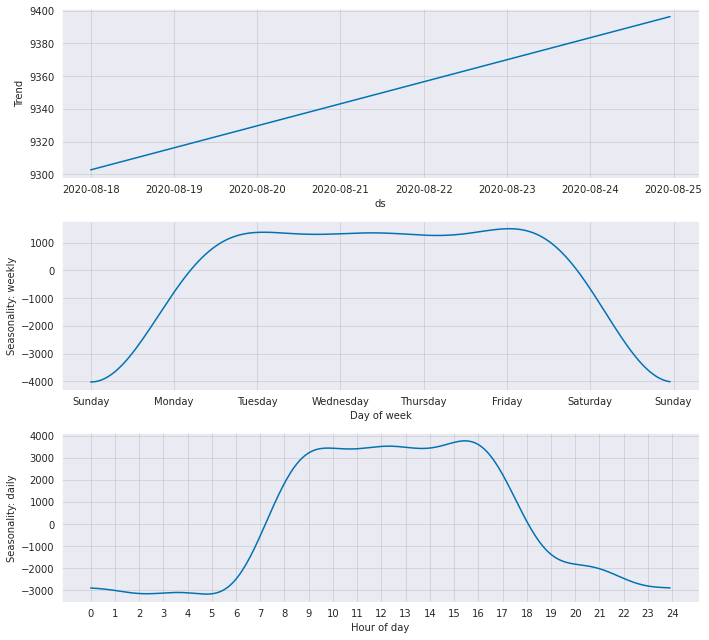

In [85]:
model.plot_components(forecast)

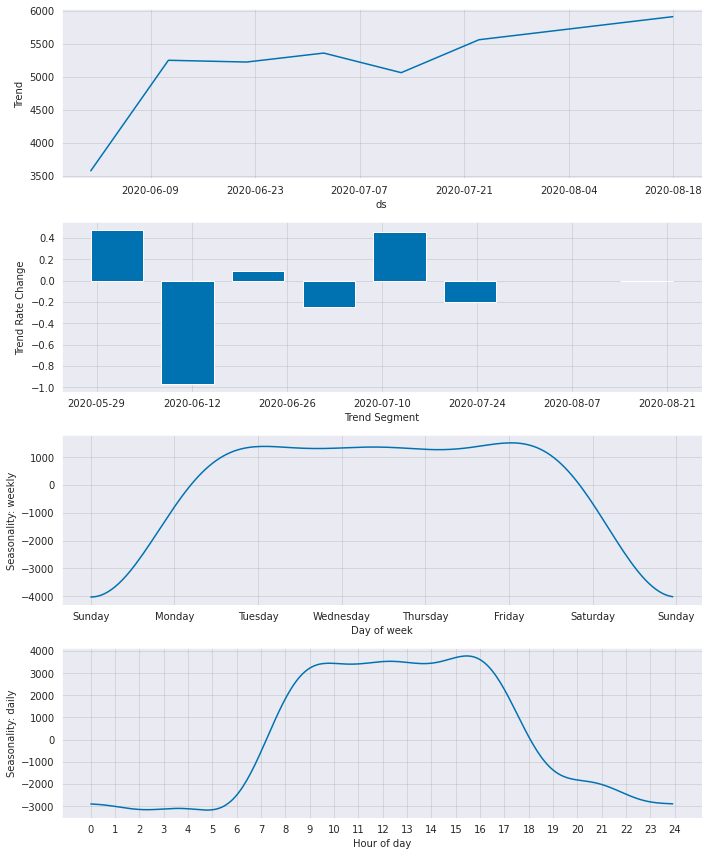

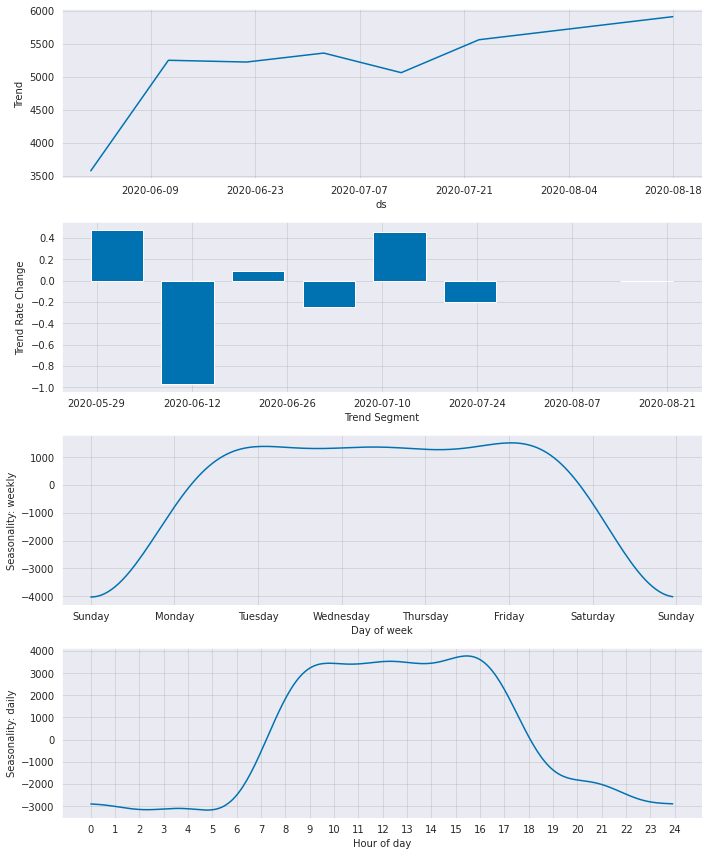

In [86]:
model.plot_parameters()

하이퍼 파라미터 적용하기
--

훈련/검증에 사용되는 데이터:
1. validate_each_epoch— 각 시기의 유효성 검사 데이터에 대한 모델 성능을 검증할지 여부를 나타내는 플래그이다.

2. valid_p — 유효성 검사에 사용해야 하는 데이터의 비율을 나타내는 0과 1 사이의 플로트이다.

3. plot_live_loss - 모델의 훈련 및 검증 손실에 대한 라이브 플롯 생성 여부를 나타내는 플래그이다.

4. epochs — 모델이 훈련되어야 하는 에포크 수이다.

하이퍼 파라미터

1. n_changepoints — 데이터의 광범위한 트렌드(증가율)가 변화하는  포인트 수를 지정한다.

2. trend_reg - 변경 지점 선택의 유연성을 제어하는 정규화 파라미터. 값이 클수록(0.001–100)
 변경 지점의 변동성이 제한된다. 값이 작을수록(~0.001–1.0) 변경 지점의 변동성이 커진다.

In [ ]:
answer=[]

for i in range(1,61):
    fb_1=fb_train_tn.loc[fb_train_tn['num']==i]
    fb_2=fb_1.drop(['num'], axis=1)
    model=NeuralProphet()
    model.fit(fb_81, validate_each_epoch=True, valid_p=0.01, freq='H', plot_live_loss=True, epochs=10)
    future=model.make_future_dataframe(fb_2, periods=168)
    forecast=model.predict(future)
    pred=forecast['yhat1']
    answer.append(pred)
    i+=1

In [127]:
import numpy as np

answer2=pd.DataFrame(answer)
answer3=np.array(answer2)
answer4=answer3.reshape(-1,1)
answer5=pd.DataFrame(answer4)

In [128]:
df_sample_submission['answer']=answer5[0]

In [129]:
from sklearn.metrics import mean_squared_error

y_test_pred=df_sample_submission['answer']
rmse=(np.sqrt(mean_squared_error(y_test, y_test_pred)))

print('rmse 는', format(rmse), '입니다.')

rmse 는 8194.47604784125 입니다.


모델 시각화
--

In [ ]:
fb_8=fb_train_tn.loc[fb_train_tn['num']==8]
fb_81=fb_8.drop(['num'], axis=1)
model=NeuralProphet()
model.fit(fb_81,validate_each_epoch=True, valid_p=0.2, freq='H', plot_live_loss=True, epochs=10)
future=model.make_future_dataframe(fb_81, periods=168)
forecast=model.predict(future)

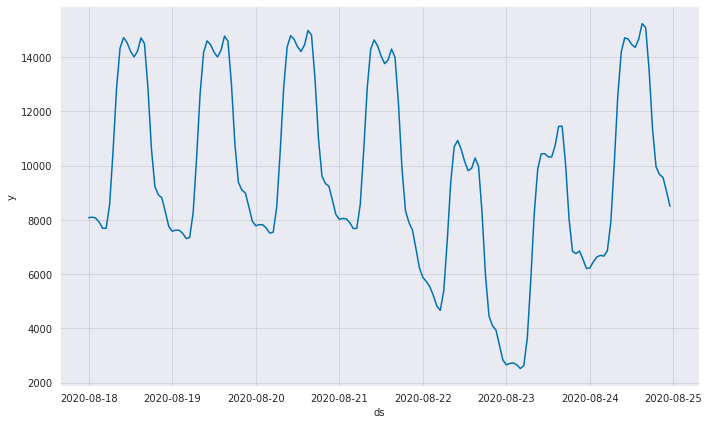

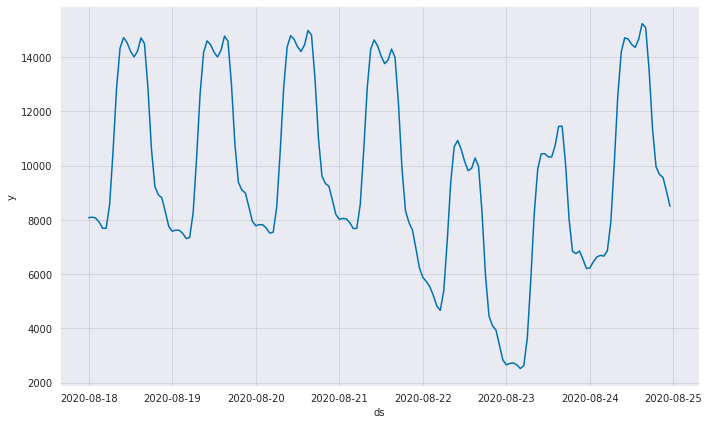

In [118]:
model.plot(forecast)

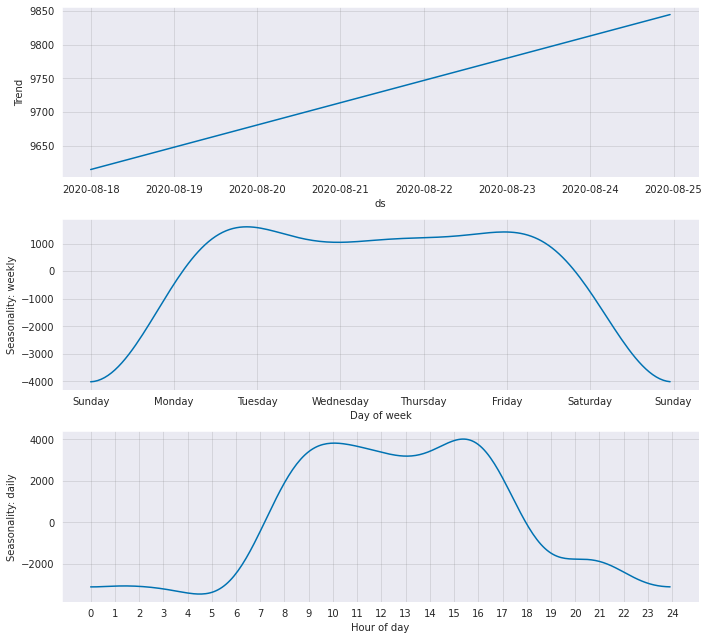

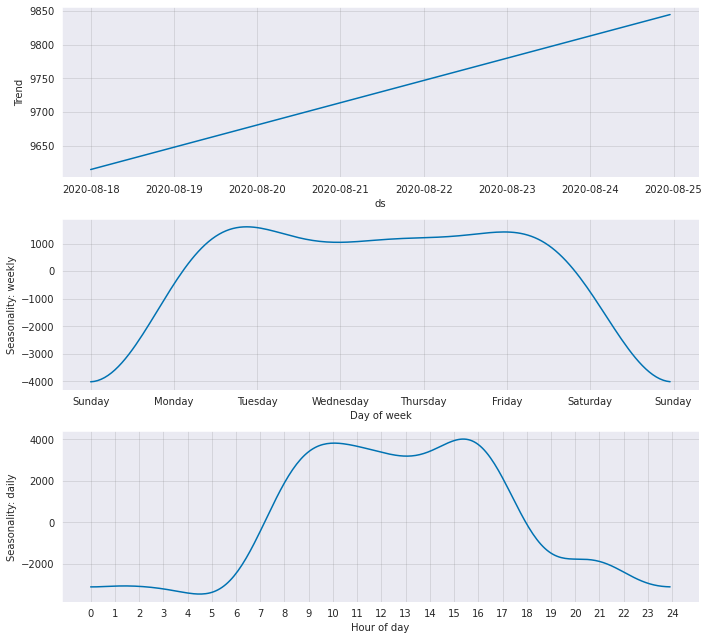

In [119]:
model.plot_components(forecast)

가장 좋은 모델에 실제 Train데이터를 적용하여 1번 회사부터 60번 회사까지 answer 리스트에 추가해줍니다.
--

submission 파일에 적용준비
--

In [87]:
fb_train.drop(['month_day'], axis=1, inplace=True)

In [88]:
fb_train

,num,ds,y
0,1,2020-06-01 00:00:00,8179.056
1,1,2020-06-01 01:00:00,8135.640
2,1,2020-06-01 02:00:00,8107.128
3,1,2020-06-01 03:00:00,8048.808
4,1,2020-06-01 04:00:00,8043.624
...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368
122396,60,2020-08-24 20:00:00,3975.696
122397,60,2020-08-24 21:00:00,3572.208
122398,60,2020-08-24 22:00:00,3299.184


In [ ]:
answer=[]

for i in range(1,61):
    fb_1=fb_train.loc[fb_train['num']==i]
    fb_2=fb_1.drop(['num'], axis=1)
    model=NeuralProphet()
    model.fit(fb_2, freq='H')
    future=model.make_future_dataframe(fb_2, periods=168)
    forecast=model.predict(future)
    pred=forecast['yhat1']
    answer.append(pred)
    i+=1

In [90]:
import numpy as np

answer2=pd.DataFrame(answer)
answer3=np.array(answer2)
answer4=answer3.reshape(-1,1)
answer5=pd.DataFrame(answer4)

In [91]:
df_sample_submission['answer']=answer5[0]

In [111]:
df_sample_submission

,num_date_time,answer
0,1 2020-08-25 00,8679.118164
1,1 2020-08-25 01,8657.989258
2,1 2020-08-25 02,8641.426758
3,1 2020-08-25 03,8627.476562
4,1 2020-08-25 04,8606.621094
...,...,...
10075,60 2020-08-31 19,3983.399414
10076,60 2020-08-31 20,3932.271973
10077,60 2020-08-31 21,3831.968750
10078,60 2020-08-31 22,3673.671875


In [112]:
submission2 = df_sample_submission['num_date_time']
submission2 = {"num_date_time":df_sample_submission["num_date_time"],"answer":df_sample_submission['answer']}
submission2 = pd.DataFrame(submission2)
submission2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  10080 non-null  object 
 1   answer         10080 non-null  float64
dtypes: float64(1), object(1)
memory usage: 157.6+ KB


In [113]:
submission2

,num_date_time,answer
0,1 2020-08-25 00,8679.118164
1,1 2020-08-25 01,8657.989258
2,1 2020-08-25 02,8641.426758
3,1 2020-08-25 03,8627.476562
4,1 2020-08-25 04,8606.621094
...,...,...
10075,60 2020-08-31 19,3983.399414
10076,60 2020-08-31 20,3932.271973
10077,60 2020-08-31 21,3831.968750
10078,60 2020-08-31 22,3673.671875


In [114]:
submission2.to_csv('submission2.csv')